**To apply the Split Neural Network method for MoA prediction**  
Ref paper: [Split learning for health: Distributed deep learning without sharing raw patient data - 2018](https://arxiv.org/pdf/1812.00564.pdf)

#**1. Pre-processing**

**Mount to Google Drive to get input datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')  
path_in = '/content/drive/My Drive/Colab Notebooks/MoA/input'
path_out = '/content/drive/My Drive/Colab Notebooks/MoA/output'

Mounted at /content/drive


**Install iterative-stratification: to stratify multilabel data**  
https://github.com/trent-b/iterative-stratification

In [2]:
pip install iterative-stratification

**Import libs**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                        ModelCheckpoint, 
                                        EarlyStopping)
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from time import time
import os
import gc
import datetime

np.random.seed(42)
tf.random.set_seed(42)
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True) # Accelerated Linear Algebra enabled
print('Accelerated Linear Algebra enabled')

print('Input files: ')
for dirname, _, filenames in os.walk(path_in):
  for filename in filenames:
    print(os.path.join(dirname, filename))

Tensorflow version 2.3.0
Accelerated Linear Algebra enabled
Input files: 
/content/drive/My Drive/Colab Notebooks/MoA/input/test_features.csv
/content/drive/My Drive/Colab Notebooks/MoA/input/sample_submission.csv
/content/drive/My Drive/Colab Notebooks/MoA/input/train_features.csv
/content/drive/My Drive/Colab Notebooks/MoA/input/train_targets_scored.csv
/content/drive/My Drive/Colab Notebooks/MoA/input/train_targets_nonscored.csv


#**2. Get Input datasets**

In [4]:
%%time
train_features = pd.read_csv(os.path.join(path_in, 'train_features.csv'))
train_targets = pd.read_csv(os.path.join(path_in, 'train_targets_scored.csv'))
test_features = pd.read_csv(os.path.join(path_in, 'test_features.csv'))
submission = pd.read_csv(os.path.join(path_in, 'sample_submission.csv'))

CPU times: user 3.86 s, sys: 282 ms, total: 4.14 s
Wall time: 5.8 s


In [5]:
def preprocess(df):
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    del df['sig_id']
    return df

train = preprocess(train_features)
test = preprocess(test_features)
del train_targets['sig_id']  

**To get feature importance**  
Using permutation important method with eli5 library.  
Ref: https://www.kaggle.com/dansbecker/permutation-importance  
The result is below.


In [6]:
top_features = \
     [  0,   1,   2,   3,   5,   6,   8,   9,  10,  11,  12,  14,  15,
        16,  18,  19,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  44,  45,  46,
        48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 195,
       197, 198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 263, 265, 266, 268, 270, 271, 272, 273, 275, 276, 277, 279,
       282, 283, 286, 287, 288, 289, 290, 294, 295, 296, 297, 299, 300,
       301, 302, 303, 304, 305, 306, 308, 309, 310, 311, 312, 313, 315,
       316, 317, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 338, 339, 340, 341, 343, 344, 345, 346, 347,
       349, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 368, 369, 370, 371, 372, 374, 375, 376, 377,
       378, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 397, 398, 399, 400, 401, 403, 405, 406, 407,
       408, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 468, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 482,
       483, 485, 486, 487, 488, 489, 491, 492, 494, 495, 496, 500, 501,
       502, 503, 505, 506, 507, 509, 510, 511, 512, 513, 514, 516, 517,
       518, 519, 521, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       549, 550, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 569, 570, 571, 572, 573, 574, 575, 577, 580,
       581, 582, 583, 586, 587, 590, 591, 592, 593, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 605, 607, 608, 609, 611, 612, 613, 614,
       615, 616, 617, 619, 622, 623, 625, 627, 630, 631, 632, 633, 634,
       635, 637, 638, 639, 642, 643, 644, 645, 646, 647, 649, 650, 651,
       652, 654, 655, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668,
       669, 670, 672, 674, 675, 676, 677, 678, 680, 681, 682, 684, 685,
       686, 687, 688, 689, 691, 692, 694, 695, 696, 697, 699, 700, 701,
       702, 703, 704, 705, 707, 708, 709, 711, 712, 713, 714, 715, 716,
       717, 723, 725, 727, 728, 729, 730, 731, 732, 734, 736, 737, 738,
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751,
       752, 753, 754, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765,
       766, 767, 769, 770, 771, 772, 774, 775, 780, 781, 782, 783, 784,
       785, 787, 788, 790, 793, 795, 797, 799, 800, 801, 805, 808, 809,
       811, 812, 813, 816, 819, 820, 821, 822, 823, 825, 826, 827, 829,
       831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 844, 845,
       846, 847, 848, 850, 851, 852, 854, 855, 856, 858, 860, 861, 862,
       864, 867, 868, 870, 871, 873, 874]

In [7]:
print(len(top_features))

696


#**3. Model**

In [8]:
def create_model(num_cols, hidden_units, dropout_rate, lr):
  '''
  Args:
  Input:
  num_cols: number of columns (features) to run the model
  hidden_units: a dictionary to store the hidden units for each split NN as well
                as the aggreation NN.
    Example: 
    hidden_units = {'in1': [1024, 512, 1024],
                    'in2': [512, 1024, 512], 
                    'in3': [512, 1024, 2048, 1024, 512],
                    'agg': [1024, 1024]}  
  dropout_rate: a dictionary to store dropout rate for each split NN as well as 
                the aggreation NN.
    Example:
    dropout_rate = {'in1': 0.3,
                    'in2': 0.2,
                    'in3': 0.2,
                    'agg': 0.3}
  lr: learning rate
  Output:
  return a model
  '''
  # INPUT 1
  in1 = tf.keras.layers.Input(shape=(num_cols, ))
  x1 = tf.keras.layers.BatchNormalization()(in1)
  for unit in hidden_units['in1']:
    x1 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(unit, activation='elu'))(x1)
    x1 = tf.keras.layers.Dropout(dropout_rate['in1'])(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
  
  # INPUT 2
  in2 = tf.keras.layers.Input(shape=(num_cols, ))
  x2 = tf.keras.layers.BatchNormalization()(in2)
  for unit in hidden_units['in2']:
    x2 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(unit, activation='elu'))(x2)
    x2 = tf.keras.layers.Dropout(dropout_rate['in2'])(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
  
  # INPUT 3
  in3 = tf.keras.layers.Input(shape = (num_cols, ))
  x3 = tf.keras.layers.BatchNormalization()(in3)
  for unit in hidden_units['in3']:
    x3 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(unit, activation='elu'))(x3)
    x3 = tf.keras.layers.Dropout(dropout_rate['in3'])(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)

  # AGGREGATION Neural Network
  x = tf.keras.layers.Concatenate()([x1, x2, x3])
  x = tf.keras.layers.Dropout(dropout_rate['agg'])(x)
  x = tf.keras.layers.BatchNormalization()(x)
  for unit in hidden_units['agg']:
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(unit, activation='elu'))(x)
    x = tf.keras.layers.Dropout(dropout_rate['agg'])(x)
    x = tf.keras.layers.BatchNormalization()(x)

  #  OUTPUT
  out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation='sigmoid'))(x)

  # MODEL
  model = tf.keras.models.Model(inputs=[in1, in2, in3], outputs=out)
  model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr), sync_period=10),
                loss='binary_crossentropy')
  return model

In [9]:
def log_loss_metric(y_true, y_pred):
  '''
  To evaluate the performance of the model
  Ref: https://www.kaggle.com/c/lish-moa/overview/evaluation
  '''
  metrics = []
  for target_col in train_targets.columns:
    loss = log_loss(y_true.loc[:, target_col], y_pred[:, target_col].astype(float), labels=[0, 1])
    metrics.append(loss)
  return np.mean(metrics)

##**Example: Visualize Model Structure**

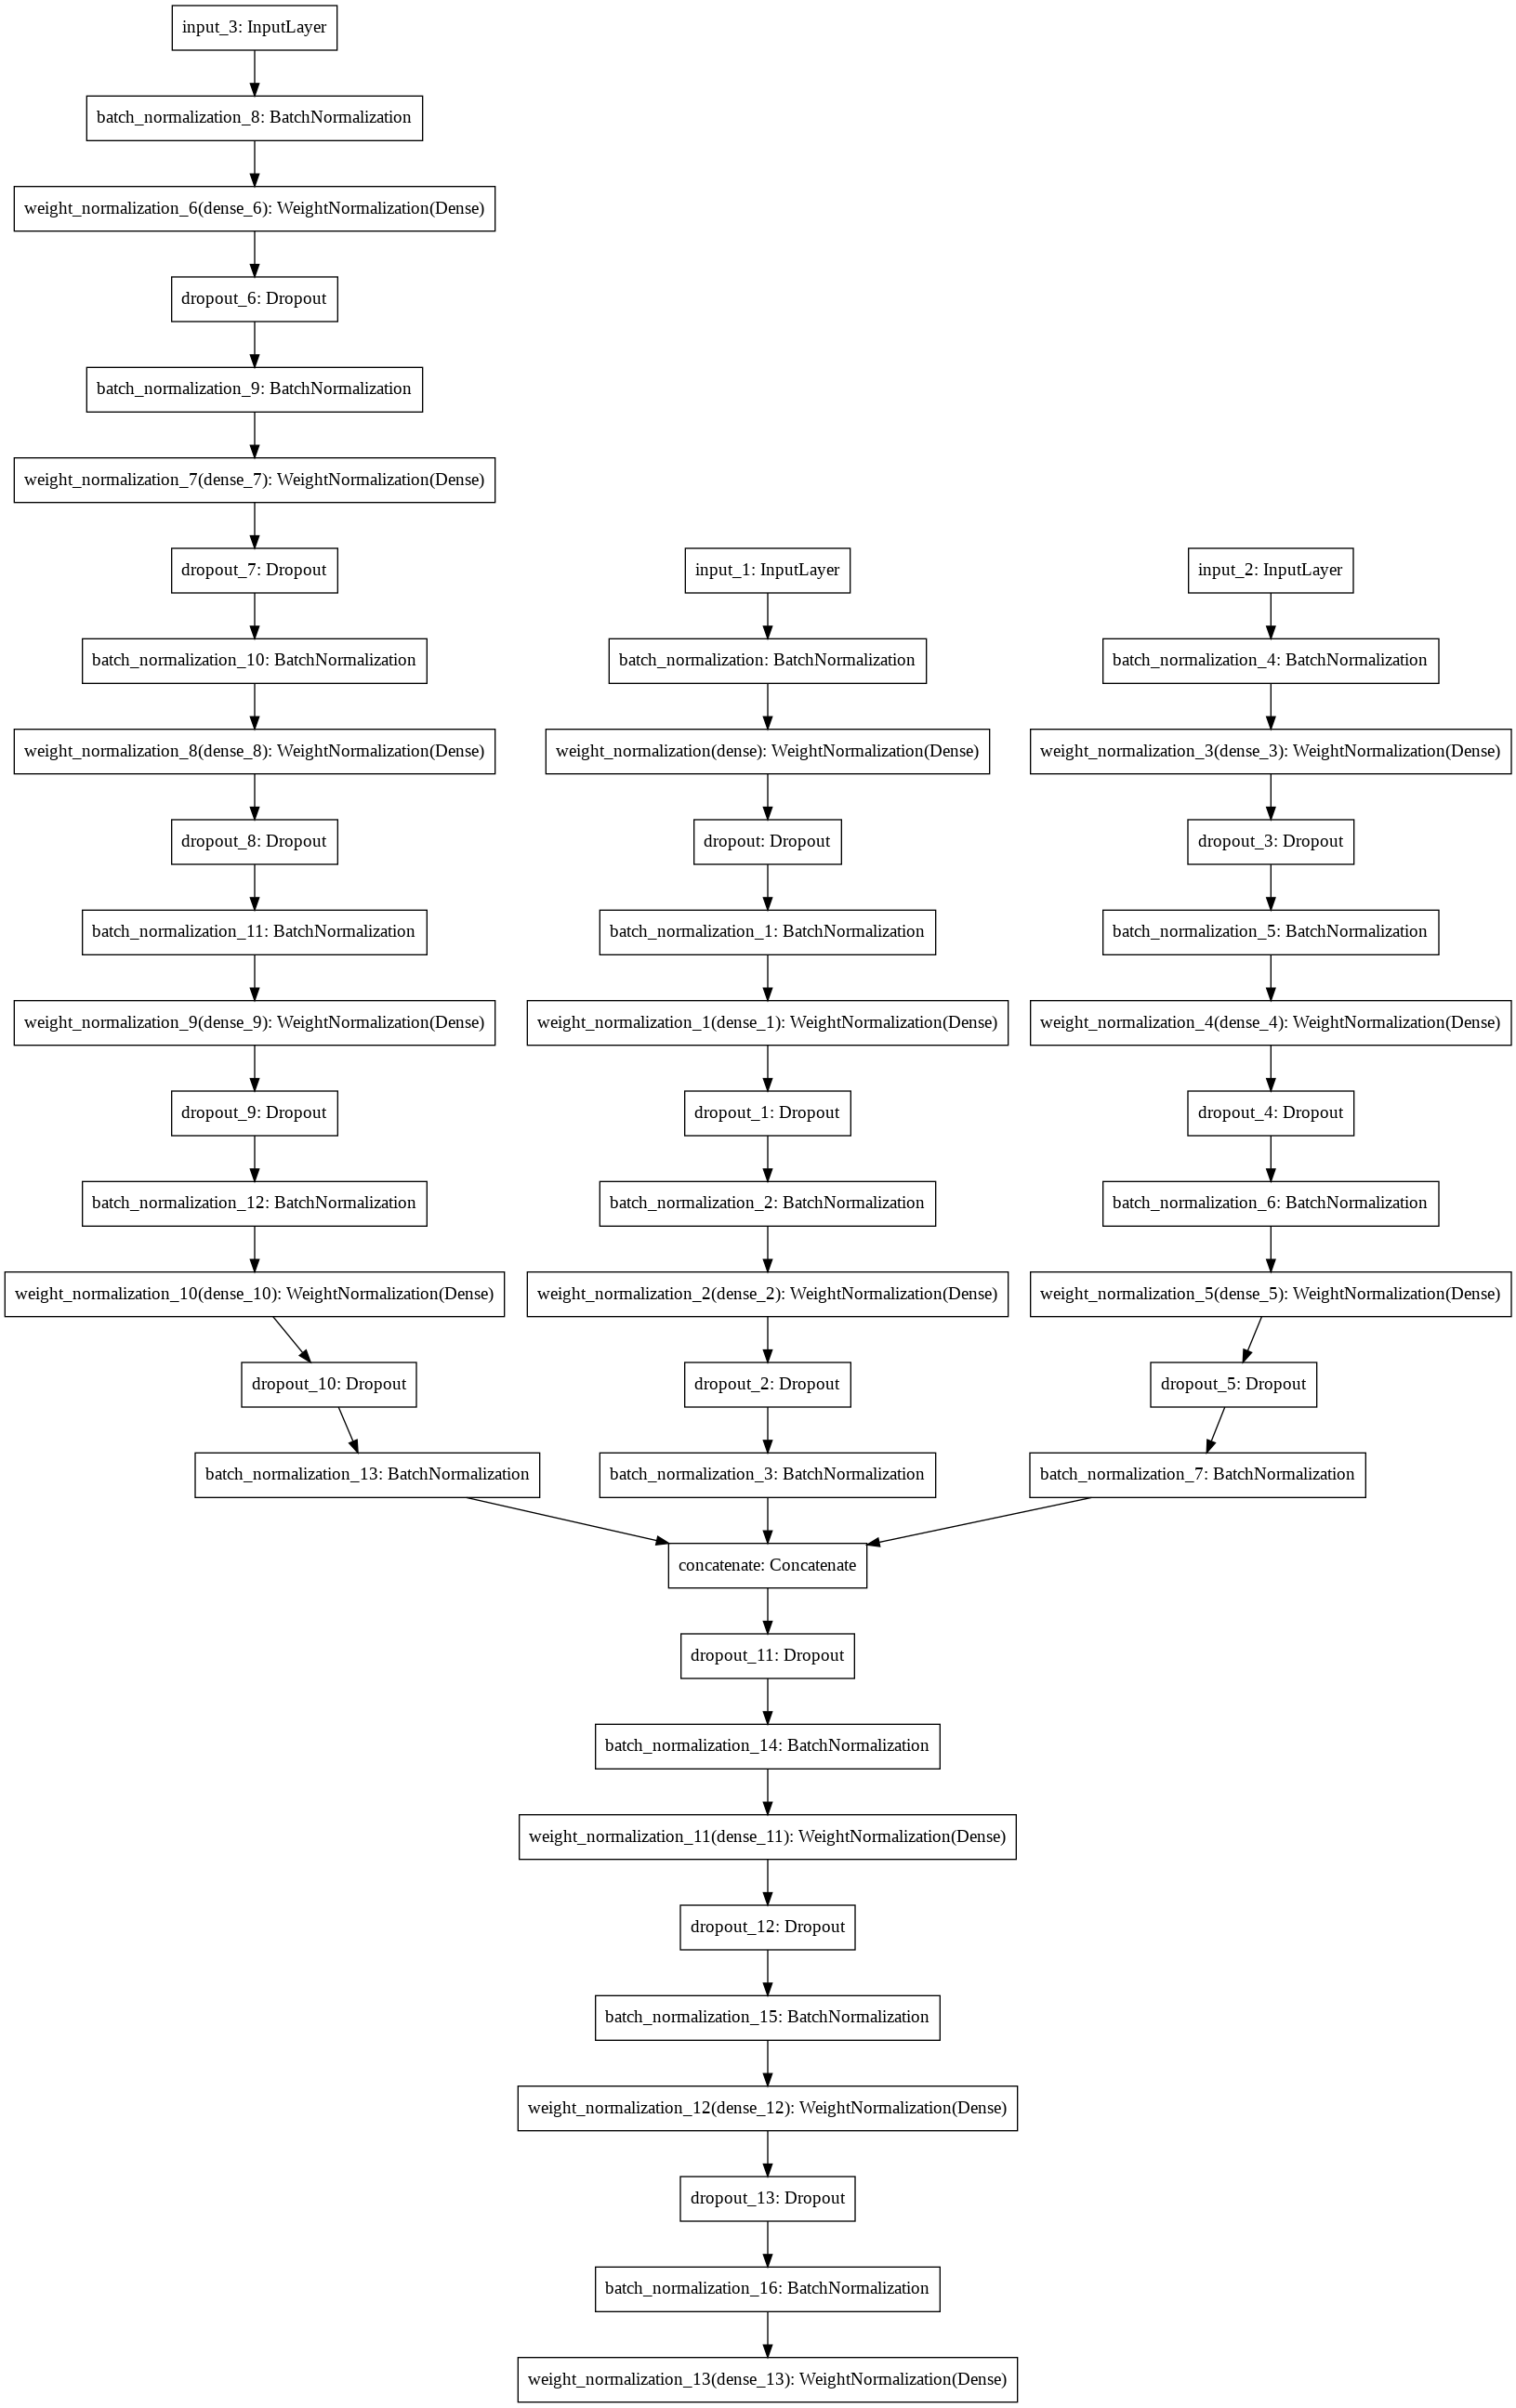

In [10]:
hidden_units = {'in1': [1024, 512, 1024],
                'in2': [512, 1024, 512], 
                'in3': [512, 1024, 2048, 1024, 512],
                'agg': [1024, 1024]}  
dropout_rate = {'in1': 0.3,
                'in2': 0.2,
                'in3': 0.2,
                'agg': 0.3}

num_cols = int(np.ceil(0.8 * len(train.columns.values)))
model = create_model(num_cols, hidden_units, dropout_rate, lr=1e-3)
tf.keras.utils.plot_model(model, )

tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=True,
                          rankdir='TB', expand_nested=False, dpi=96)


#**4. Train Model**  
For each split, we use 80% of top features as input.

In [ ]:
hidden_units = {'in1': [1024, 512, 1024],
                'in2': [512, 1024, 512], 
                'in3': [512, 1024, 2048, 1024, 512],
                'agg': [1024, 1024]}  
dropout_rate = {'in1': 0.3,
                'in2': 0.2,
                'in3': 0.2,
                'agg': 0.3}

# num_cols = int(np.ceil(0.8 * len(train.columns.values)))
num_cols = int(np.ceil(0.8 * len(top_features)))

res = train_targets.copy()  # results
res.loc[:, train_targets.columns] = 0
submission.loc[:, train_targets.columns] = 0
N_STARTS = 3
fp_split_nn_hdf5=os.path.join(path_out, 'split_nn.hdf5')

for seed in range(N_STARTS):
  # Make num_cols for in1, in2 and in3
  split_cols = []
  for _ in range(len(hidden_units) - 1):
    split_cols.append(np.random.choice(top_features, num_cols))
  
  for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits=5, 
                                                         random_state=seed, 
                                                         shuffle=True).split(train_targets, train_targets)):
    # Note tr and te are indices
    start_time = time()
    print(f'start_time = {start_time}')
    x_tr = [train.values[tr][:, split_cols[0]], # in1: train features
            train.values[tr][:, split_cols[1]], # in2: train features
            train.values[tr][:, split_cols[2]]] # in3: train features
    x_val = [train.values[te][:, split_cols[0]], # in1: validation features
             train.values[te][:, split_cols[1]], # in2: validation features
             train.values[te][:, split_cols[2]]] # in3: validation features
    y_tr = train_targets.astype(float).values[tr] # train target for in1, in2 and in3
    y_val = train_targets.astype(float).values[te] # test target for in1, in2 and in3
    x_tt = [test_features.values[:, split_cols[0]], # in1: test features
            test_features.values[:, split_cols[1]], # in2: test features
            test_features.values[:, split_cols[2]]] # in3: test features

    # Model
    model = create_model(num_cols, hidden_units, dropout_rate, lr=1e-3)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                            min_delta=1e-4, min_lr=1e-5, mode='min')
    ckp = ModelCheckpoint(filepath=fp_split_nn_hdf5, 
                          monitor='val_loss', verbose = 0, save_best_only=True, 
                          save_weights_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, 
                       mode='min', baseline=None, restore_best_weights=True, 
                       verbose=0)
    history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), 
                        epochs=100, batch_size=128, callbacks=[rlr, ckp, es], 
                        verbose=0)
    hist = pd.DataFrame(history.history)
    model.load_weights(fp_split_nn_hdf5)
  
    # submission
    submission.loc[:, train_targets.columns] += model.predict(x_tt, batch_size=128)

    # result
    res.loc[te, train_targets.columns] += model.predict(x_val, batch_size=128)

    print(f'[{str(datetime.timedelta(seconds=time() - start_time))[2:7]}]' + 
          f'Split NN: Seed {seed}, Fold {n}:', hist['val_loss'].min())
    
    tensorflow.keras.backend.clear_session()
    del model, history, hist
    x = gc.collect()
# End of for seed in range(N_STARTS)
submission.loc[:, train_targets.columns] /= ((n + 1) * N_STARTS)
res.loc[:, train_targets.columns] /= N_STARTS

start_time = 1601387792.5238388


##**Evaluation**

In [ ]:
print(f'Split NN OOF metric: {log_loss_metric(train_targets, res)}')
res.loc[train['cp_type'] == 1, train_targets.columns] = 0
submission.loc[test['cp_type'] == 1, train_targets.columns] = 0
print(f'Split NN OOF Metric with postprocessing: {log_loss_metric(train_targets, res)}')

##**Submission**

In [ ]:
submission.to_csv(os.path.join(path_out, 'submission.csv'), index=False)